In [14]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import os
%config InlineBackend.figure_format='retina'

In [15]:
def prepare_image_EEG_nr(epoch_t, epoch_s, p3_win):
    img_dir =  '/home/zhengwei/notebooks/dataset/JANUS_imgs'
    # load EEG and corresponding images
    # for standard
    epoch_array_s = np.stack(epoch_s.values())[:,0,:]
    p3_s = epoch_array_s[:, p3_win[0]:p3_win[1]].max(axis=1).mean()
    im_ndarrays = []
    epoch_array_t = []
    nr = []
    label = [] # 1: DCGAN, 2: BEGAN, 3: PROGAN, 4: RFACE
    for key in epoch_t.keys():
        nr.append(epoch_t[key][0,p3_win[0]:p3_win[1]].max() - p3_s )
        epoch_array_t.append(epoch_t[key][0])
        im = Image.open(os.path.join(img_dir, key))
        im_ndarray = np.array(im)
        im_ndarrays.append(im_ndarray)
        if 'T_DCGAN' in key:
            label.append(1)
        elif 'T_BEGAN' in key:
            label.append(2)
        elif 'T_PROGAN' in key:
            label.append(3)
        elif 'T_RFACE' in key:
            label.append(4)

    nr = np.stack(nr).reshape(-1, 1)
    im_ndarrays = np.stack(im_ndarrays)
    epoch_array_t = np.stack(epoch_array_t)
    return epoch_array_t, epoch_array_s, im_ndarrays, nr, np.stack(label).reshape(-1,1)

def cal_p3_amp(epoch_t, epoch_s):
    p3_t = np.max(epoch_t, axis=1)
    p3_s = np.max(epoch_s, axis=1).mean()
    return p3_t - p3_s

def compute_nr(epoch_t, epoch_s):
    nr = cal_p3_amp(epoch_t, epoch_s)
    return nr.mean()



def compute_nr_mean(epoch_t, epoch_s):
    source = epoch_t.mean(axis=0) - epoch_s.mean(axis=0)
    return source.max()


# normalize the input image
def preprocess_input(X):
#     mean_ = [0.485, 0.456, 0.406]
#     std_ = [0.229, 0.224, 0.225]
    X_norm = []
    for x in X:
        x = np.divide(x, 255.0)
        x = np.subtract(x, .5)
        x = np.multiply(x, 2.0)
        X_norm.append(x)
#         x =  np.divide(x, 128.0)
#         x = np.subtract(x, 1.)
#         X_norm.append(x)

    X_norm = np.stack(X_norm)
    return X_norm

def prepare_p3_source(p3_dcgan, p3_began, p3_progan, p3_rface, label):
    p3_source_train = []
    for label_ in label:
        if label_ == 1:
            p3_source_train.append(p3_dcgan[0])
        elif label_ == 2:
            p3_source_train.append(p3_began[0])
        elif label_ == 3:
            p3_source_train.append(p3_progan[0])
        elif label_ == 4:
            p3_source_train.append(p3_rface[0])
    p3_source_train = np.stack(p3_source_train)
    return p3_source_train


EEG_path = '/home/zhengwei/notebooks/GAN/evaluate_gan/dataset/image_EEG_data'
SUB_ID = ['janus16thMay', 'janus20thMay', 'janus29thMay', 'janus17thJuly', 'janus19thJuly', 'janus9thAug', \
          'janus14thAug', 'janus15thAug', 'janus20thAug', 'janus6thNov', 'janus15thNov', 'janus19thNov']
T_IDs = ['DCGAN', 'BEGAN', 'PROGAN', 'RFACE']
epoch_subs_ids = ['sub{}'.format(i) for i in range(1,13)]
opt_ind = [102, 129, 125, 132, 100, 104, 116, 100, 107, 111, 110, 100]


# epoch_subs_ids = ['sub2']

epoch_array_t_subs = np.empty([0, 250])
epoch_array_s_subs = np.empty([0, 250])
im_ndarrays_subs = np.empty([0, 128, 128, 3]) # for inception and shallow
# im_ndarrays_subs = np.empty([0, 224, 224, 3]) # for mobilenet



nr_subs = np.empty([0, 1])
label_subs = np.empty([0, 1])
p3_baseline_subs = []
p3_dcgan_subs = np.empty([0, 250])
p3_began_subs = np.empty([0, 250])
p3_progan_subs = np.empty([0, 250])
p3_rface_subs = np.empty([0, 250])
for i, epoch_sub_id in enumerate(epoch_subs_ids):
    p3_win = [int(opt_ind[i]-25), int(opt_ind[i]+25)]
    with open('{}/{}_S.pickle'.format(EEG_path, epoch_sub_id), 'rb') as handle:
        epoch_s = pickle.load(handle, encoding='latin1')

    with open('{}/{}_T.pickle'.format(EEG_path, epoch_sub_id), 'rb') as handle:
        epoch_t = pickle.load(handle, encoding='latin1')

    epoch_array_t, epoch_array_s, im_ndarrays, nr, label = prepare_image_EEG_nr(epoch_t, epoch_s, p3_win)   
    im_ndarrays = preprocess_input(im_ndarrays)
    p3_baseline = np.max(epoch_array_s[:, p3_win[0]:p3_win[1]], axis = 1).mean(axis=0)
    p3_dcgan = np.mean(epoch_array_t[label[:,0]==1], axis=0, keepdims=True) - np.mean(epoch_array_s, axis=0, keepdims=True)
    p3_began = np.mean(epoch_array_t[label[:,0]==2], axis=0, keepdims=True) - np.mean(epoch_array_s, axis=0, keepdims=True)
    p3_progan = np.mean(epoch_array_t[label[:,0]==3], axis=0, keepdims=True) - np.mean(epoch_array_s, axis=0, keepdims=True)
    p3_rface = np.mean(epoch_array_t[label[:,0]==4], axis=0, keepdims=True) - np.mean(epoch_array_s, axis=0, keepdims=True)

    
    epoch_array_t_subs = np.r_[epoch_array_t_subs, epoch_array_t]
    epoch_array_s_subs = np.r_[epoch_array_s_subs, epoch_array_s]
    im_ndarrays_subs = np.r_[im_ndarrays_subs, im_ndarrays]
    nr_subs = np.r_[nr_subs, nr]
    label_subs = np.r_[label_subs, label]
    p3_baseline_subs.append(p3_baseline)
    p3_dcgan_subs = np.r_[p3_dcgan_subs, p3_dcgan]
    p3_began_subs = np.r_[p3_began_subs, p3_began]
    p3_progan_subs = np.r_[p3_progan_subs, p3_progan]
    p3_rface_subs = np.r_[p3_rface_subs, p3_rface]  
    

    # compute nr for different cats
    print(epoch_sub_id)
    for cat in T_IDs:
        epoch_t_ = []
        for key in epoch_t.keys():
            if cat in key:
                epoch_t_.append(epoch_t[key][0])
        epoch_t_ = np.stack(epoch_t_)
        print('{}: {}'.format(cat, compute_nr(epoch_t_[:, p3_win[0]:p3_win[1]], epoch_array_s[:, p3_win[0]:p3_win[1]]) ))
    
    print('\n')
p3_baseline_subs = np.stack(p3_baseline_subs)

Y = np.c_[epoch_array_t_subs, nr_subs, label_subs]    
# if sub_id == 'janus16thMay':
#     batch_size = 42
# else:
#     batch_size = 48
batch_size = 128    
print('available EEG trials', epoch_array_t_subs.shape[0])

sub1
DCGAN: 0.5773844130732909
BEGAN: 0.6675170388885293
PROGAN: 0.6845382677475358
RFACE: 0.6412800022706485


sub2
DCGAN: 0.6128322979230609
BEGAN: 0.7685414889546852
PROGAN: 0.9389079182847797
RFACE: 0.8197694486654773


sub3
DCGAN: 0.44568696524530865
BEGAN: 0.6304410627070831
PROGAN: 0.6890422608636503
RFACE: 0.5913261807116696


sub4
DCGAN: 0.4316418356395805
BEGAN: 0.5761840142757186
PROGAN: 0.9744673865238189
RFACE: 0.9303083274620965


sub5
DCGAN: 0.6576208247846607
BEGAN: 0.906762374316105
PROGAN: 0.9383027368364042
RFACE: 0.7217306547089111


sub6
DCGAN: 0.6025220957777832
BEGAN: 0.7739764533867113
PROGAN: 0.9646343716735594
RFACE: 0.8114619131384386


sub7
DCGAN: 0.4619730876231838
BEGAN: 0.5836175622940426
PROGAN: 0.8564983792866895
RFACE: 0.8116791615343842


sub8
DCGAN: 0.8239750255001282
BEGAN: 0.8379381221491335
PROGAN: 0.8817393178749624
RFACE: 0.7891165731419673


sub9
DCGAN: 0.6822904076715403
BEGAN: 0.7226243507205125
PROGAN: 0.9113484683756407
RFACE: 0.90821099492

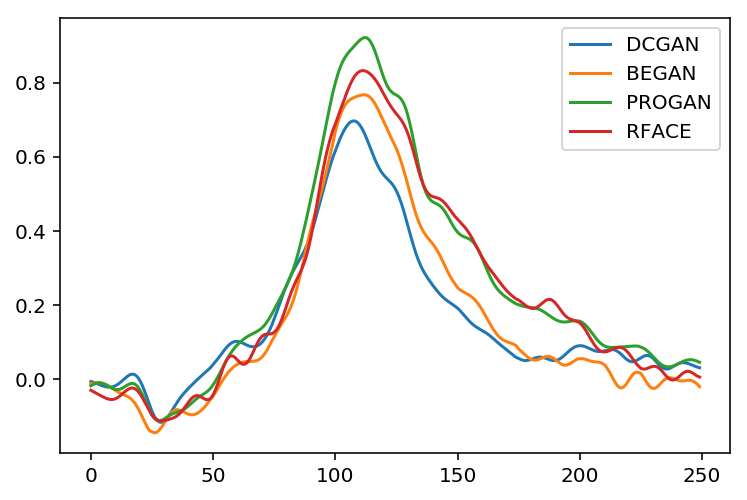

In [33]:
plt.figure()
plt.plot(p3_dcgan_subs.mean(axis=0))
plt.plot(p3_began_subs.mean(axis=0))
plt.plot(p3_progan_subs.mean(axis=0))
plt.plot(p3_rface_subs.mean(axis=0))
plt.legend(['DCGAN', 'BEGAN', 'PROGAN', 'RFACE'])